[Kaggle](https://www.kaggle.com/?utm_medium=partner&utm_source=dataquest.io&utm_campaign=dataquest+kagglefun) is a site where people create algorithms and compete against machine learning practitioners around the world. Our algorithm wins the competition if it's the most accurate on a particular data set.

In this project we'll learn how to:

* Approach a Kaggle competition
* Explore the competition data and learn about the competition topic
* Prepare data for machine learning
* Train a model
* Measure the accuracy of model
* Prepare and make first Kaggle submission.

Kaggle has created a number of competitions designed for beginners. The most popular of these competitions, and the one we'll be looking at, is about predicting which passengers survived the sinking of the [Titanic](https://en.wikipedia.org/wiki/Sinking_of_the_RMS_Titanic).

In this competition, we have a data set of different information about passengers onboard the Titanic, and we see if we can use that information to predict whether those people survived or not. Before we start looking at this specific competition, let's take a moment to understand how Kaggle competitions work.

Each Kaggle competition has two key data files that we will work with - a **training set** and a **testing set**.

Once we have trained our model on the training set, we will use that model to make predictions on the data from the testing set, and submit those predictions to Kaggle

In [1]:
import pandas as pd

test = pd.read_csv("test.csv")

train = pd.read_csv("train.csv")

The files we read are available on the [data page for the Titanic competition on Kaggle](https://www.kaggle.com/c/titanic/data). That page also has a data dictionary, which explains the various columns that make up the data set. Below are the descriptions contained in that data dictionary:

* `PassengerID` - A column added by Kaggle to identify each row and make submissions easier
* `Survived` - Whether the passenger survived or not and the value we are predicting (0=No, 1=Yes)
* `Pclass` - The class of the ticket the passenger purchased (1=1st, 2=2nd, 3=3rd)
* `Sex` - The passenger's sex
* `Age` - The passenger's age in years
* `SibSp` - The number of siblings or spouses the passenger had aboard the Titanic
* `Parch` - The number of parents or children the passenger had aboard the Titanic
* `Ticket` - The passenger's ticket number
* `Fare` - The fare the passenger paid
* `Cabin` - The passenger's cabin number
* `Embarked` - The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton)

The data page on Kaggle has some additional notes about some of the columns. It's always worth exploring this in detail to get a full understanding of the data.

The type of machine learning we will be doing is called **classification**, because when we make predictions we are classifying each passenger as survived or not. More specifically, we are performing **binary classification**, which means that there are only two different states we are classifying.

In any machine learning exercise, thinking about the topic we are predicting is very important. We call this step **acquiring domain knowledge**, and it's one of the most important determinants for success in machine learning.

In this case, understanding the Titanic disaster and specifically what variables might affect the outcome of survival is important. Anyone who has watched the movie Titanic would remember that women and children were given preference to lifeboats (as they were in real life). We would also remember the vast class disparity of the passengers.

This indicates that `Age`, `Sex`, and `PClass` may be good predictors of survival. We'll start by exploring `Sex` and `Pclass` by visualizing the data.

Because the Survived column contains `0` if the passenger did not survive and `1` if they did, we can segment our data by `sex` and calculate the mean of this column

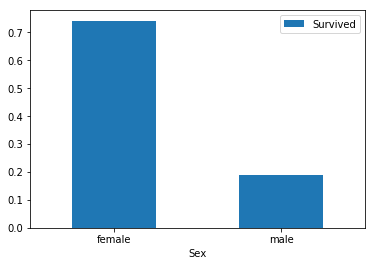

In [11]:
import matplotlib.pyplot as plt
sex_pivot = train.pivot_table(index = "Sex", values = "Survived")
sex_pivot.plot.bar(rot = 0)
plt.show()

We can immediately see that **females** survived in much higher proportions than **males** did.

Let's do the same with the `Pclass` column.

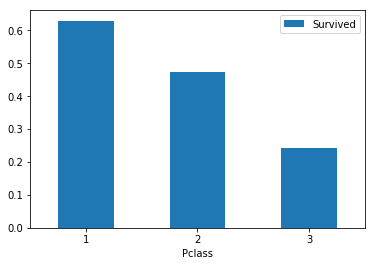

In [14]:
class_pivot = train.pivot_table(index = "Pclass", values = "Survived")

class_pivot.plot.bar(rot = 0)
plt.show()

The `Sex` and `PClass` columns are what we call categorical features. That means that the values represented a few separate options (for instance, whether the passenger was male or female).

Let's take a look at the `Age` column

In [15]:
print(train["Age"].describe())

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


The `Age` column contains numbers ranging from **0.42 to 80.0** (If we look at Kaggle's data page, it informs us that `Age` is fractional if the passenger is less than one). The other thing to note here is that there are **714 values** in this column, fewer than the **891 rows** that the train data set had which indicates we have some missing values.

All of this means that the `Age` column needs to be treated slightly differently, as this is a continuous numerical column. One way to look at distribution of values in a continuous numerical set is to use histograms. We can create two histograms to compare visually the those that survived vs those who died across different age ranges:

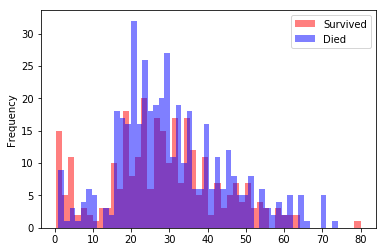

In [16]:
survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]
survived["Age"].plot.hist(alpha=0.5,color='red',bins=50)
died["Age"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['Survived','Died'])
plt.show()

The relationship here is not simple, but we can see that in some age ranges more passengers survived - where the red bars are higher than the blue bars.

In order for this to be useful to our machine learning model, we can separate this continuous feature into a categorical feature by dividing it into ranges. We can use the `pandas.cut()` function to help us out.

The `pandas.cut()` function has two required parameters - the column we wish to cut, and a list of numbers which define the boundaries of our cuts. We are also going to use the optional parameter labels, which takes a list of labels for the resultant bins. This will make it easier for us to understand our results.

Before we modify this column, we have to be aware of two things. 
* Firstly, any change we make to the train data, we also need to make to the test data, otherwise we will be unable to use our model to make predictions for our submissions. 
* Secondly, we need to remember to handle the missing values we observed above.

In [24]:
def process_age(df,cut_points, label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"], cut_points,labels = label_names)
    return df

In [25]:
cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing", "Infant", "Child","Teenager","Young Adult", "Adult", "Senior"]

train = process_age(train,cut_points,label_names)
test = process_age(test,cut_points,label_names)

In [26]:
train["Age_categories"].value_counts()

Young Adult    358
Adult          195
Missing        177
Teenager        70
Infant          44
Child           25
Senior          22
Name: Age_categories, dtype: int64

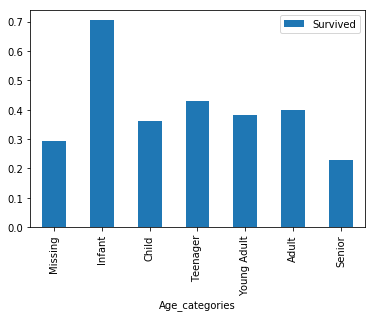

In [27]:
pivot = train.pivot_table(index = "Age_categories", values = "Survived")
pivot.plot.bar()
plt.show()

So far we have identified three columns that may be useful for predicting survival:

* `Sex`
* `Pclass`
* `Age`, or more specifically our newly created `Age_categories`

Before we build our model, we need to prepare these columns for machine learning. Most machine learning algorithms can't understand text labels, so we have to convert our values into numbers.

Additionally, we need to be careful that we don't imply any numeric relationship where there isn't one. If we think of the values in the `Pclass` column, we know they are `1`, `2`, and `3`.

While the class of each passenger certainly has some sort of ordered relationship, the relationship between each class is not the same as the relationship between the numbers `1`, `2`, and `3`. For instance, **class 2** isn't **worth** double what **class 1** is, and **class 3** isn't **worth** triple what **class 1** is.

In order to remove this relationship, we can create dummy columns for each unique value in `Pclass`

In [38]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [39]:
train = create_dummies(train,"Pclass")
test = create_dummies(test,"Pclass")

In [40]:
train = create_dummies(train, "Sex")
test = create_dummies(test, "Sex")

train = create_dummies(train, "Age_categories")
test = create_dummies(test, "Age_categories")

Now that our data has been prepared, we are ready to train our first model. The first model we will use is called **Logistic Regression**, which is often the first model we will train when performing classification.

In [41]:
columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train[columns], train["Survived"])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

We've trained our first machine learning model! Our next step is to find out how accurate our model is, and to do that, we'll have to make some predictions.

If we recall from earlier, we do have a test dataframe that we could use to make predictions. We could make predictions on that data set, but because it doesn't have the `Survived` column we would have to submit it to Kaggle to find out our accuracy. This would quickly become a pain if we had to submit to find out the accuracy every time we optimized our model.

We could also fit and predict on our train dataframe, however if we do this there is a high likelihood that our model will **overfit**, which means it will perform well because we're testing on the same data we've trained on, but then perform much worse on new, unseen data.

Instead we can split our train dataframe into two:

* One part to train our model on (often 80% of the observations)
* One part to make predictions with and test our model (often 20% of the observations)

The convention in machine learning is to call these two parts train and test. This can become confusing, since we already have our test dataframe that we will eventually use to make predictions to submit to Kaggle. To avoid confusion, from here on, we're going to call this Kaggle **test** data **holdout** data, which is the technical name given to this type of data used for final predictions.

The scikit-learn library has a handy `model_selection.train_test_split()` [function](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) that we can use to split our data. `train_test_split()` accepts two parameters, `X` and `y`, which contain all the data we want to train and test on, and returns four objects: `train_X`, `train_y`, `test_X`, `test_y`

In [43]:
from sklearn.model_selection import train_test_split

all_x = train[columns]
all_y = train["Survived"]

train_x, test_x, train_y, test_y = train_test_split(all_x, all_y,test_size = 0.2, random_state = 0)

There are two other parameters we used: `test_size`, which lets us control what proportions our data are split into, and `random_state`. The `train_test_split()` function randomizes observations before dividing them, and setting a random seed means that our results will be reproducible, which is important if we are collaborating, or need to produce consistent results each time (which our answer checker requires)

In [45]:
lr = LogisticRegression()
lr.fit(train_x, train_y)
predictions = lr.predict(test_x)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


There are a number of ways to measure the accuracy of machine learning models, but when competing in Kaggle competitions we want to make sure we use the same method that Kaggle uses to calculate accuracy for that specific competition.

In this case, the evaluation section for the Titanic competition on Kaggle tells us that our score calculated as **the percentage of passengers correctly predicted**. This is by far the most common form of accuracy for **binary classification**.

scikit-learn has a handy function we can use to calculate accuracy: [metrics.accuracy_score()](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html). The function accepts two parameters, `y_true` and `y_pred`, which are the actual values and our predicted values respectively, and returns our accuracy score

In [46]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_y, predictions)
accuracy

0.8100558659217877

Our model has an accuracy score of **81.0% when tested against our 20% test set**. Given that this data set is quite small, there is a good chance that our model is overfitting, and will not perform as well on totally unseen data.

To give us a better understanding of the real performance of our model, we can use a technique called **cross validation** to train and test our model on different splits of our data, and then average the accuracy scores.

The most common form of cross validation, and the one we will be using, is called **k-fold cross validation**. **Fold** refers to each different iteration that we train our model on, and **k** just refers to the number of folds.

We will use scikit-learn's [model_selection.cross_val_score()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) function to automate the process.

In [49]:
from sklearn.model_selection import cross_val_score
import numpy as np

lr = LogisticRegression()

scores = cross_val_score(lr,all_x, all_y, cv =10)
accuracy = np.mean(scores)
accuracy

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

0.8024670865963002

From the results of our **k-fold validation**, we can see that the accuracy number varies with each fold - ranging between **76.4% and 87.6%**. This demonstrates why cross validation is important.

As it happens, our average accuracy score was **80.2%**, which is not far from the **81.0%** we got from our simple **train/test split**, however this will not always be the case, and we should always use cross-validation to make sure the error metrics we are getting from our model are accurate.

We are now ready to use the model we have built to train our final model and then make predictions on our unseen holdout data, or what Kaggle calls the **test** data set.

In [53]:
holdout = test
lr = LogisticRegression()
lr.fit(all_x,all_y)
holdout_predictions = lr.predict(holdout[columns])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The last thing we need to do is create a submission file. Each Kaggle competition can have slightly different requirements for the submission file. Here's what is specified on the [Titanic competition evaluation page](https://www.kaggle.com/c/titanic#evaluation):

You should submit a csv file with exactly **418 entries plus a header row**. Our submission will show an error if we have extra columns (beyond `PassengerId` and `Survived`) or rows.

The file should have exactly 2 columns:

* `PassengerId` (sorted in any order)
* `Survived` (contains your binary predictions: **1 for survived**, **0 for deceased**)

We will need to create a new dataframe that contains the **holdout_predictions** we created and the `PassengerId` column from the holdout dataframe. We don't need to worry about matching the data up, as both of these remain in their original order.

In [54]:
holdout_ids = holdout["PassengerId"]
submission = pd.DataFrame({"PassengerId": holdout_ids, "Survived" : holdout_predictions})
submission.to_csv("submission.csv", index = False)

Now that we have our submission file, we can start our submission to Kaggle by clicking the blue **Submit Predictions** button on the [competition page](https://www.kaggle.com/c/titanic).

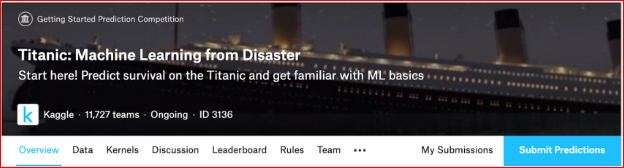

We will then be prompted to upload our CSV file, and add a brief description of our submission. When we make our submission, Kaggle will process our predictions and give us our accuracy for the holdout data and our ranking. When it is finished processing we will see our first submission gets an **accuracy score of 0.75598, or 75.6%**. It's easy to look at Kaggle leaderboards after our first submission and get discouraged, but keep in mind that this is just a starting point.

It's also very common to see a small number of scores of **100% at the top of the Titanic leaderboard** and think that we have a long way to go. In reality, anyone scoring about **90% on this competition** is likely cheating (it's easy to look up the names of the passengers in the holdout set online and see if they survived).

There is a great analysis on Kaggle, [How am I doing with my score](https://www.kaggle.com/pliptor/how-am-i-doing-with-my-score/notebook), which uses a few different strategies and suggests a minimum score for this competition is **62.7% (achieved by presuming that every passenger died) and a maximum of around 82%**. We are a little over halfway between the minimum and maximum, which is a great starting point.

There are many things we can do to improve the accuracy of our model.

* Improving the features:
 * Feature Engineering: Create new features from the existing data.
 * Feature Selection: Select the most relevant features to reduce noise and overfitting.
* Improving the model:
 * Model Selection: Try a variety of models to improve performance.
 * Hyperparameter Optimization: Optimize the settings within each particular machine learning model.